# Plot SWOT fields and spectra 

In this script we read in the SWOT data from a Pass between specified lats and plot the fields and spectra and generate Fig. 1 of the balanced extraction paper

In [1]:
import jws_swot_tools as swot
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


┌ Warning: CHOLMOD version incompatibility
│ 
│ Julia was compiled with CHOLMOD version 4.0.4. It is
│ currently linked with version 5.3.1.
│ This might cause Julia to terminate when working with
│ sparse matrix factorizations, e.g. solving systems of
│ equations with \.
│ 
│ It is recommended that you use Julia with the same major
│ version of CHOLMOD as the one used during the build, or
│ download the generic binaries from www.julialang.org,
│ which ship with the correct versions of all dependencies.
└ @ SparseArrays.CHOLMOD ~/miniconda3/envs/d3/share/julia/stdlib/v1.10/SparseArrays/src/solvers/cholmod.jl:206


### Import SWOT data and files first for a pass between specified lats

In [2]:
# Read in the SWOT data for this pass
pass_num = 9
lat_max = 35 #38 #38
lat_min = 28 #28 #28

data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/'

# finds overlapping cycles between the karin and nadir datasets
_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_num) 

sample_index = 2 # this is an index we use to import a preliminary file and get track indices 
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims_SWOT = [len(shared_cycles), track_length, track_length_nadir]

karin, nadir = swot.init_swot_arrays(dims_SWOT, lat_min, lat_max, pass_num)

# read and process the karin data
swot.load_karin_data(karin_files, lat_min, lat_max, karin, verbose=False)
swot.process_karin_data(karin)

# read and process the nadir data
swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir)
swot.process_nadir_data(nadir)

# generate the coordinates
karin.coordinates()
nadir.coordinates()

# Compute spectra
karin.compute_spectra()
nadir.compute_spectra()

/home/jskinner1/SWOT_tools/src/jws_swot_tools/import_and_process.py:286: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varts = np.nanvar(ssha_array, axis=(1, 2))


Overall SSH variance (overall_var): 0.017270098252846422
----------------------------------
Total Number of Good KaRIn strips : 186
Number of Quality Masked KaRIn strips : 127
Number of High Variance strips removed : 0
Number of Good Cycles: 93
Number of Cycles dropped (>20% masked): 2
----------------------------------

Number of good nadir cycles: 95
Number of bad nadir cycles: 0
X grid range (km): 0.00 to 256.41 (span: 256.41 km)
Y grid range (km): 0.00 to 797.81 (span: 797.81 km)
Track Length: 797.81 km
Swath Width: 128.20 km
Karin spacing: dx = 2.00 km, dy = 2.00 km
Nadir spacing: dy = 6.85 km
Computing KaRIn spectra...
Computing Nadir spectra...


### Plot the fields and spectra 

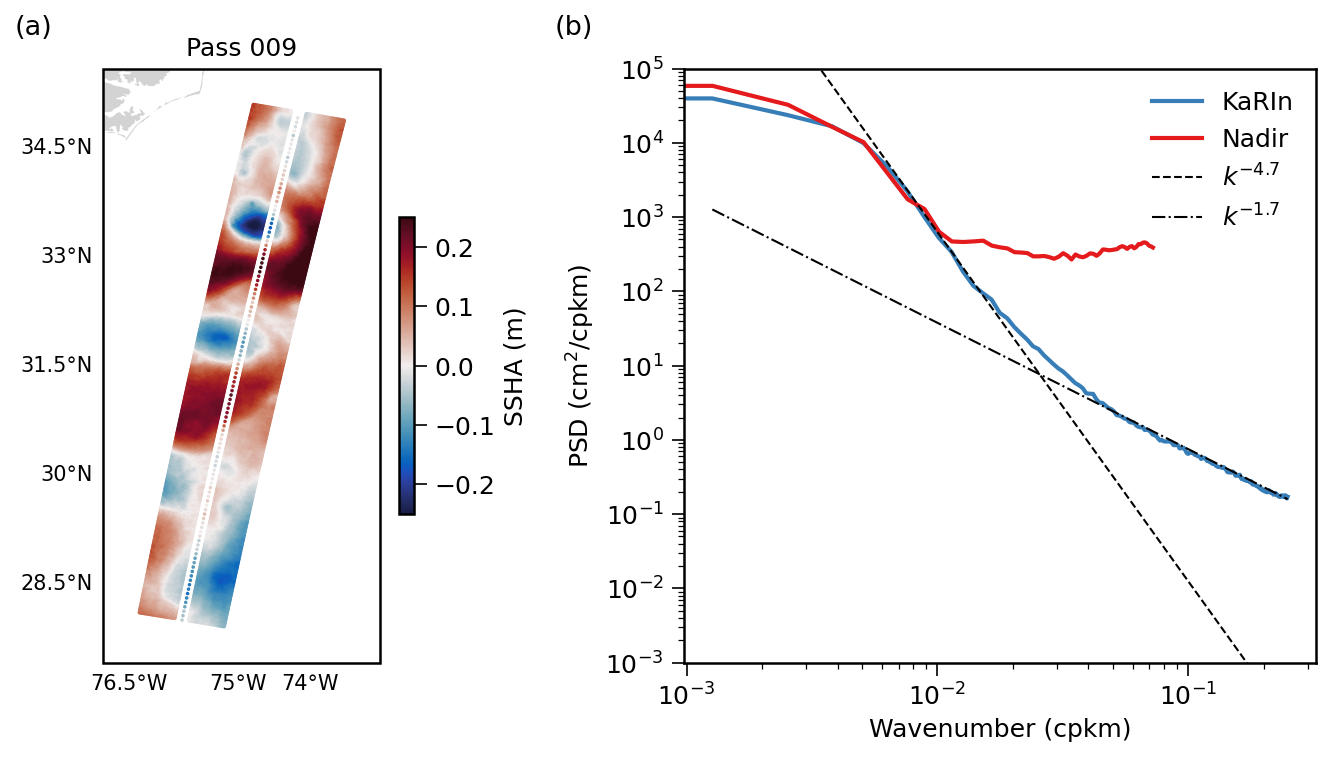

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy
import cartopy.crs as ccrs
import numpy as np
import cmocean

swot.set_plot_style()

index = 6
vmin, vmax = -0.25, 0.25
ylims = (1e-3, 1e5)
cmap = 'cmo.balance'

fig = plt.figure(figsize=(10, 5), dpi=150)
gs = GridSpec(1, 2, width_ratios=[1, 1.0], figure=fig)

# ───── SWOT Map ─────
# Define padding in degrees
pad = 0.5

lon_min = np.nanmin(karin.lon[index]) - pad
lon_max = np.nanmax(karin.lon[index]) + pad
lat_min = np.nanmin(karin.lat[index]) - pad
lat_max = np.nanmax(karin.lat[index]) + pad

ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax0.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

sc0 = ax0.scatter(
    karin.lon[index], karin.lat[index],
    c=karin.ssha[index], s=1, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
ax0.scatter(
    nadir.lon[index], nadir.lat[index],
    c=nadir.ssh[index], s=0.5, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
#ax0.coastlines()
ax0.add_feature(cartopy.feature.LAND, facecolor='lightgrey', edgecolor='none', zorder=0)
ax0.set_title(f'Pass {pass_num:03d}')
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl0.top_labels = gl0.right_labels = False
cbar0 = fig.colorbar(sc0, ax=ax0, orientation='vertical', shrink=0.5, pad=0.03)
cbar0.set_label("SSHA (m)")

# ───── Power Spectrum ─────
ax1 = fig.add_subplot(gs[0, 1])

ax1.loglog(karin.wavenumbers_cpkm,  karin.spec_ssha, label='KaRIn', linewidth=2.)
ax1.loglog(nadir.wavenumbers_cpkm,  nadir.spec_ssha, label='Nadir', linewidth=2.)
#ax1.loglog(karin.wavenumbers * 1e3, karin.spec_ssh, label='SWOT KaRIn SSH', linewidth=2.0)
#ax1.loglog(karin.wavenumbers * 1e3, karin.spec_tmean, label='SWOT Time-mean', linewidth=2.0)
#ax1.loglog(karin.wavenumbers * 1e3, karin.spec_tide, label='SWOT HRET', linewidth=2.0)

# Reference slope lines (k^-5 and k^-2)
k_ref = karin.wavenumbers_cpkm  # range of wavenumbers (cpkm)
C1 = 2.5e-7  # vertical placement for k^-5
C2 = 1.5e-2  # vertical placement for k^-2
ax1.loglog(k_ref, C1 * k_ref**-4.7, 'k--', linewidth=1, label=r'$k^{-4.7}$')
ax1.loglog(k_ref, C2 * k_ref**-1.7, 'k', linestyle='-.', linewidth=1, label=r'$k^{-1.7}$')

ax1.set_xlabel("Wavenumber (cpkm)")
ax1.set_ylabel("PSD (cm$^2$/cpkm)")
ax1.set_ylim(ylims)
ax1.legend()

# (a) for left panel
fig.text(0.13, 1, "(a)", fontsize=13, 
         va="top", ha="center")

# (b) for right panel
fig.text(0.49, 1, "(b)", fontsize=13, 
         va="top", ha="center")

plt.tight_layout()
fig.savefig("swot_map_spectrum.pdf", bbox_inches='tight')
plt.show()

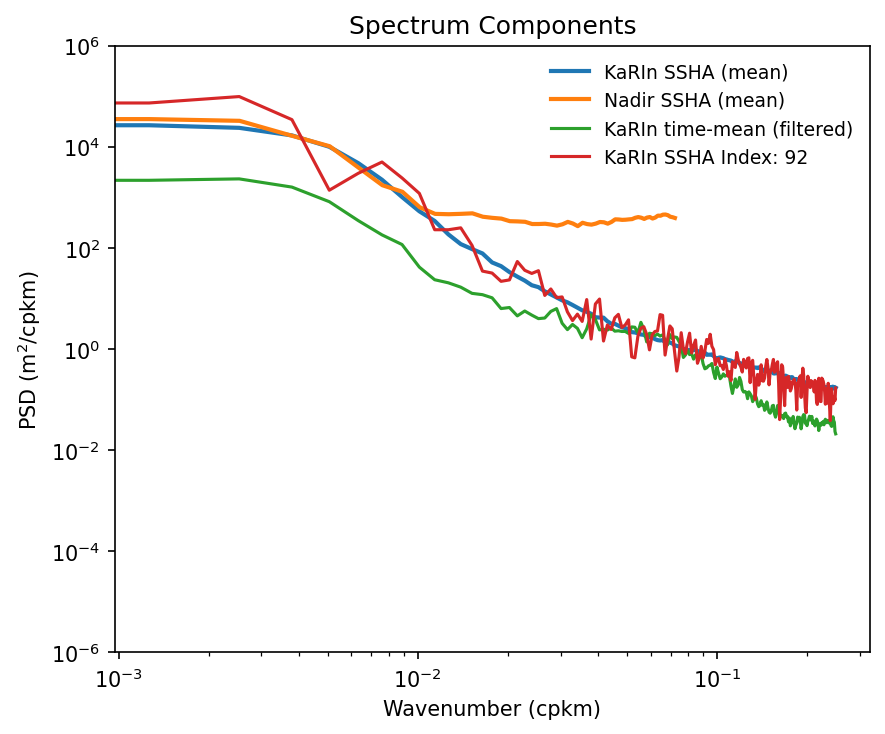

In [9]:
# --- Single-panel final spectrum plot ---
ylims = (1e-6, 1e6)
index = 92 

def _safe_loglog(ax, x, y, *args, **kwargs):
    if y is None:
        return
    y_plot = np.asarray(y)
    if y_plot.ndim == 0:
        return
    ax.loglog(x, y_plot, *args, **kwargs)

kx_karin = karin.wavenumbers_cpkm
kx_nadir = nadir.wavenumbers_cpkm

fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

# KaRIn components
_safe_loglog(ax, kx_karin, karin.spec_alongtrack_av, label='KaRIn SSHA (mean)', linewidth=2)
_safe_loglog(ax, kx_nadir, nadir.spec_alongtrack_av, label='Nadir SSHA (mean)', linewidth=2)
# _safe_loglog(ax, kx_karin, karin.spec_ssh,        label='KaRIn SSH', linewidth=1.5)
# _safe_loglog(ax, kx_karin, karin.spec_tmean,      label='KaRIn time-mean', linewidth=1.5)
_safe_loglog(ax, kx_karin, karin.spec_filt_tmean, label='KaRIn time-mean (filtered)', linewidth=1.5)
# _safe_loglog(ax, kx_karin, karin.spec_tide,       label='Tide', linewidth=1.5)
_safe_loglog(ax, kx_karin, karin.spec_alongtrack_ins[index], label=f'KaRIn SSHA Index: {index}', linewidth=1.5)

ax.set_xlabel('Wavenumber (cpkm)')
ax.set_ylabel('PSD (m$^2$/cpkm)')
ax.set_ylim(ylims)
ax.legend(frameon=False, fontsize=9)
ax.set_title('Spectrum Components')

plt.tight_layout()
plt.show()

## Fit Spectrum Models

### Averaged across the track 


---- KaRIn spectrum parameters ----
Amp. balanced   :   2.5969e+04 ± 2.63e+02
lambda balanced :   2.2317e+02 ± 1.58e+00
slope balanced  :   4.6841e+00 ± 5.73e-02
Amp. noise      :   4.0667e+01 ± 3.92e+01
lambda noise    :   1.0001e+02 ± 5.84e+01
slope noise     :   1.7535e+00 ± 2.61e-02


---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 326.1484544366737 ± 1.54e+01



(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>],
       dtype=object))

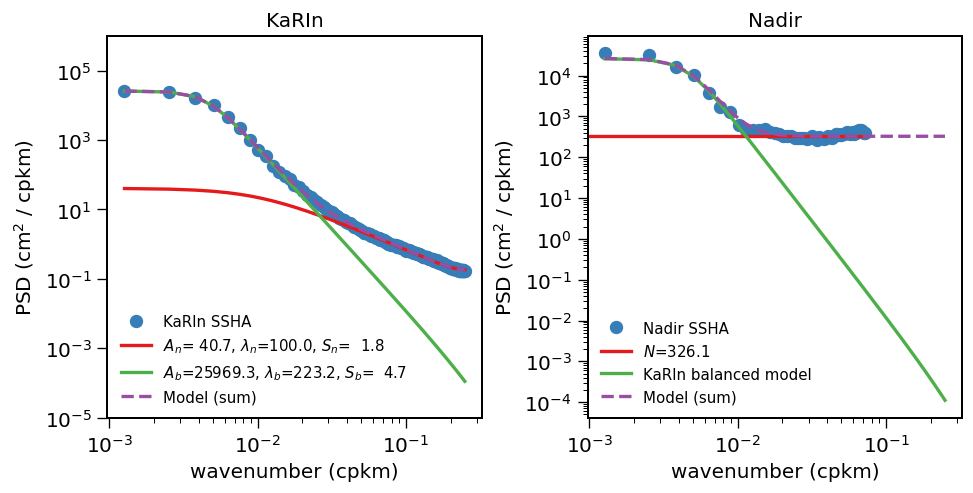

In [4]:
# KaRIn model fit
poptcwg_karin, pcovcwg_karin = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
poptcwg_nadir, covcwg_nadir = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, poptcwg_karin)

# Plot the fits
swot.plot_spectral_fits(karin, nadir, poptcwg_karin, poptcwg_nadir, 'balanced_fits.pdf')

### Make the Combined Plot (Fig. 1)

2023-04-29T00:35:08.553165000
505
KaRIn crossover: k = 0.0266 cpkm  (λ ≈ 37.6 km)
Nadir crossover: k = 0.0114 cpkm  (λ ≈ 87.5 km)


/scratch/jskinner1/job_45052182/ipykernel_2810436/274315675.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


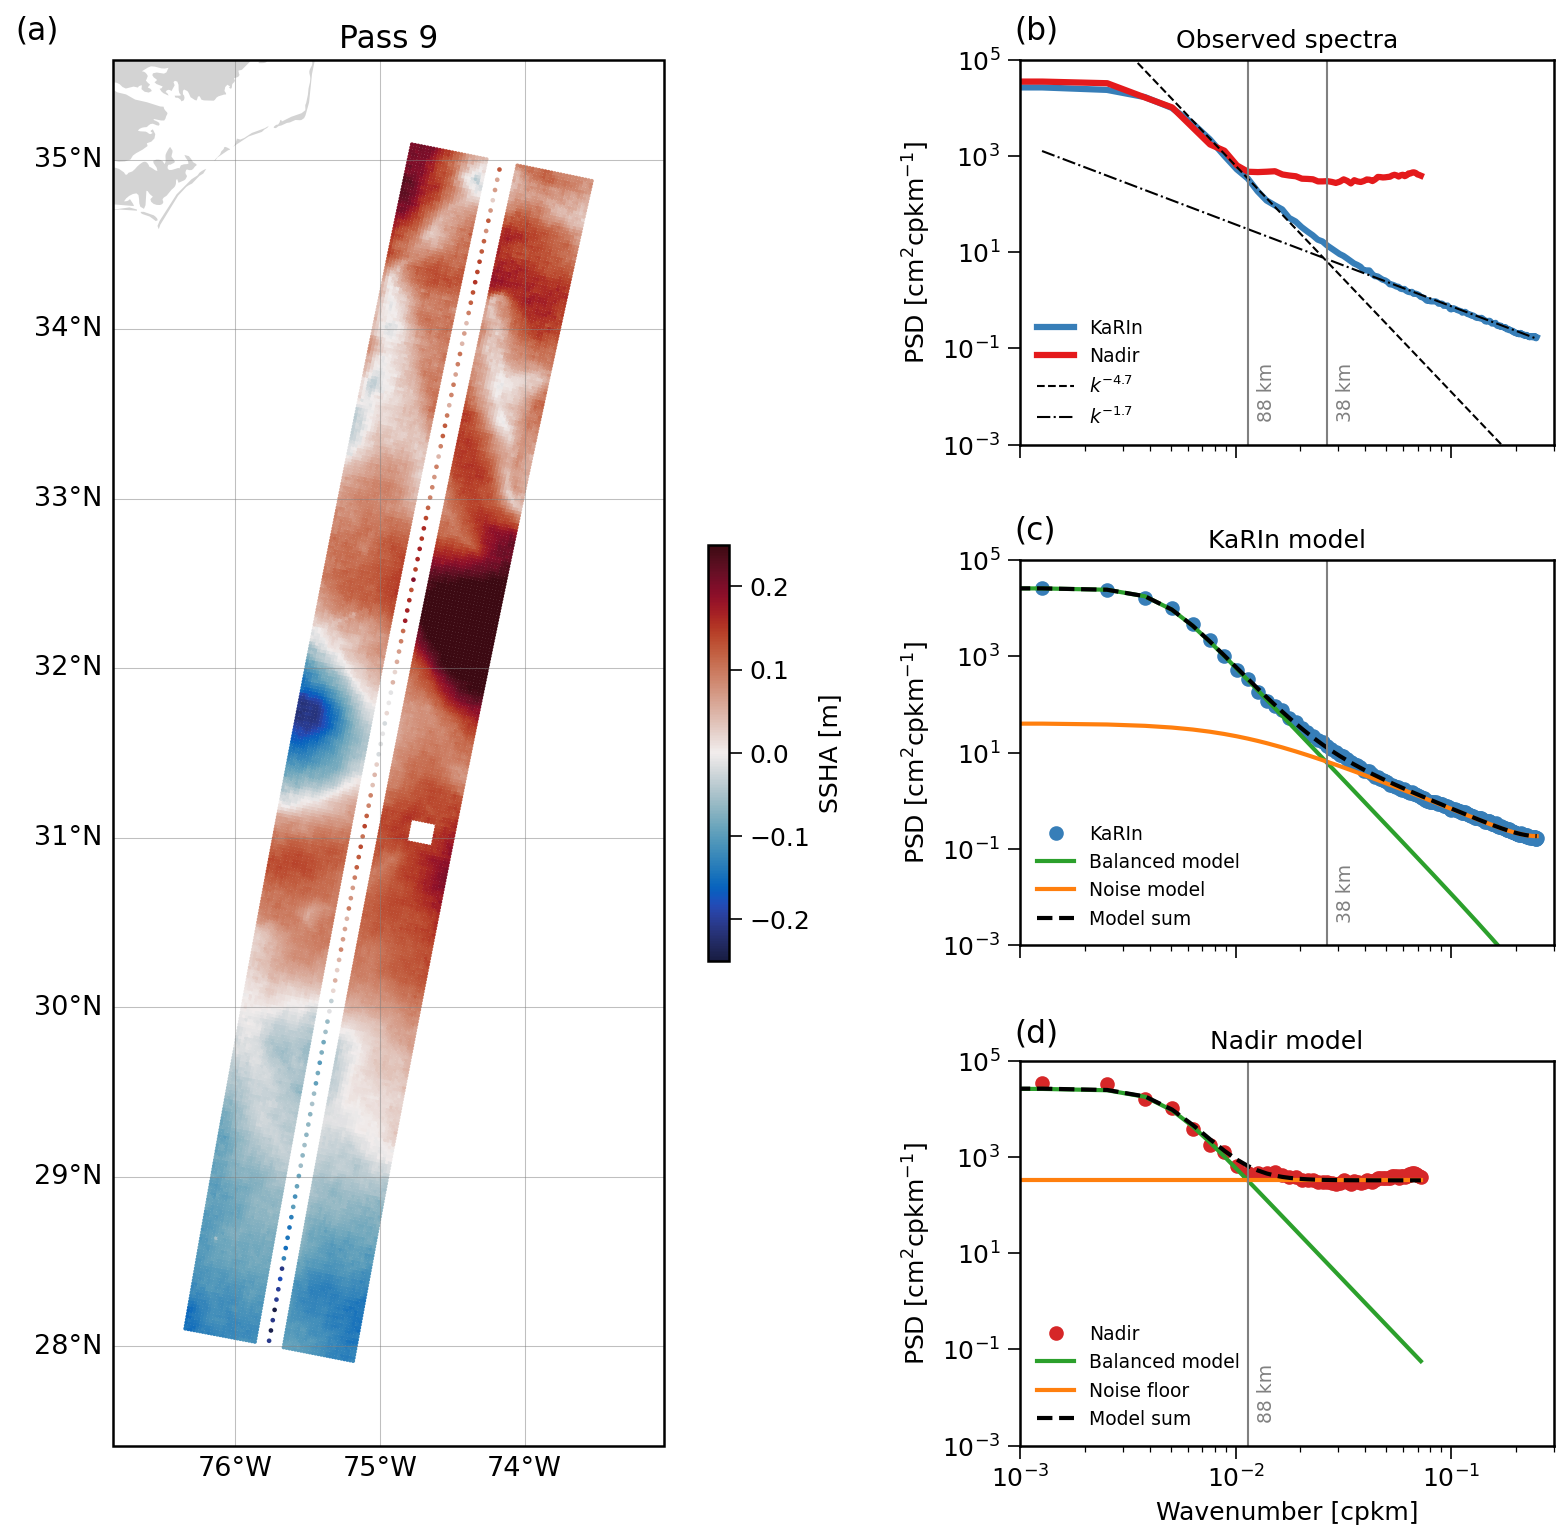

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# optional style (if available)
try:
    swot.set_plot_style()
except Exception:
    pass

# index for the pass to plot
index = 28
print(karin.time_dt[index])

print(shared_cycles[index])

# one-sided wavenumbers & spectra (take positive half)
tlen_k = int(karin.track_length // 2)
tlen_n = int(nadir.track_length // 2)

k_karin = np.asarray(karin.wavenumbers_cpkm[tlen_k:])
karin_spec = np.asarray(karin.spec_alongtrack_av[tlen_k:])

k_nadir = np.asarray(nadir.wavenumbers_cpkm[tlen_n:])
nadir_spec = np.asarray(nadir.spec_alongtrack_av[tlen_n:])

# model components
sp_balanced_karin = swot.balanced_model_tapered(k_karin, *poptcwg_karin[0:3])
sp_unbalanced_karin = swot.unbalanced_model_tapered(k_karin, *poptcwg_karin[3:6])
model_sum_karin = sp_balanced_karin + sp_unbalanced_karin

sp_noise_nadir = swot.nadir_noise_model(k_nadir, poptcwg_nadir[0])
sp_balanced_nadir = swot.balanced_model(k_nadir, *poptcwg_karin[0:3])
model_sum_nadir = sp_balanced_nadir + sp_noise_nadir

# --- shared x-axis limits ---
kmin = 1e-3
kmax = 3e-1

# figure layout: left large map, right column with 3 stacked spectra (sharing x)
fig = plt.figure(figsize=(12, 12), dpi=150)
gs = GridSpec(nrows=3, ncols=2, figure=fig,
              width_ratios=[2.0, 1.2], height_ratios=[1, 1, 1],
              hspace=0.3, wspace=0.25)

fig.subplots_adjust(left=0.01)  # push leftmost column all the way left

# ----- Large map (left column spanning all rows) -----
ax_map = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
pad = 0.5
lon_min = np.nanmin(karin.lon[index]) - pad
lon_max = np.nanmax(karin.lon[index]) + pad
lat_min = np.nanmin(karin.lat[index]) - pad
lat_max = np.nanmax(karin.lat[index]) + pad
ax_map.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
# --- Set true aspect ratio for latitude 31.5° ---
phi = np.deg2rad(31.5)
ax_map.set_aspect(1 / np.cos(phi))  # ~1.17 scaling at 31.5°

sc = ax_map.scatter(karin.lon[index], karin.lat[index],
                    c=karin.ssha[index], s=1.0, cmap='cmo.balance',
                    vmin=-0.25, vmax=0.25, transform=ccrs.PlateCarree(),
                    marker='o', rasterized=True, zorder=2)
ax_map.scatter(nadir.lon[index], nadir.lat[index],
               c=nadir.ssh[index], s=1.5, cmap='cmo.balance',
               vmin=-0.25, vmax=0.25, transform=ccrs.PlateCarree(),
               marker='o', rasterized=True, zorder=1)
ax_map.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=0)
#ax_map.coastlines(resolution='50m', linewidth=0.5, zorder=3)
gl = ax_map.gridlines(draw_labels=True, linewidth=0.5,color='gray',linestyle='-',alpha=0.5)

gl.xlocator = plt.MultipleLocator(1)
gl.ylocator = plt.MultipleLocator(1)
gl.top_labels = False
gl.right_labels = False
ax_map.set_title(f'Pass {pass_num:01d}', fontsize=15)
cbar = fig.colorbar(sc, ax=ax_map, orientation='vertical', shrink=0.3, pad=0.05)
cbar.set_label('SSHA [m]')

# increase font size for latitude/longitude labels
gl.xlabel_style = {'size': 13}  # longitude labels
gl.ylabel_style = {'size': 13}  # latitude labels

# --- Y-limits for PSD ---
ylims = (1e-3, 1e5)

# create three stacked spectra sharing x-axis
ax_top  = fig.add_subplot(gs[0, 1])
ax_mid  = fig.add_subplot(gs[1, 1], sharex=ax_top)
ax_bot  = fig.add_subplot(gs[2, 1], sharex=ax_top)

# ----- Top-right: observed spectra -----
ax_top.loglog(k_karin, karin_spec, label='KaRIn', linewidth=3.0)
ax_top.loglog(k_nadir, nadir_spec, label='Nadir', linewidth=3.0)
ax_top.loglog(k_ref, C1 * k_ref**-4.7, 'k--', linewidth=1, label=r'$k^{-4.7}$')
ax_top.loglog(k_ref, C2 * k_ref**-1.7, 'k', linestyle='-.', linewidth=1, label=r'$k^{-1.7}$')
ax_top.set_ylabel('PSD [cm$^2$cpkm$^{-1}$]')
ax_top.set_ylim(ylims)
ax_top.set_xlim(kmin, kmax)
ax_top.set_title('Observed spectra')
ax_top.legend(fontsize=9, loc='lower left')
plt.setp(ax_top.get_xticklabels(), visible=False)

# ----- Middle-right: KaRIn data + fits -----
ax_mid.loglog(k_karin, karin_spec, 'o',markersize = 6, label='KaRIn')
ax_mid.loglog(k_karin, sp_balanced_karin, '-', color='tab:green', label='Balanced model')
ax_mid.loglog(k_karin, sp_unbalanced_karin, '-', color='tab:orange', label='Noise model')
ax_mid.loglog(k_karin, model_sum_karin, '--k', label='Model sum')
ax_mid.set_ylabel('PSD [cm$^2$cpkm$^{-1}$]')
ax_mid.set_ylim(ylims)
ax_mid.legend(fontsize=9, loc='lower left')
ax_mid.set_title('KaRIn model')
plt.setp(ax_mid.get_xticklabels(), visible=False)

# ----- Bottom-right: Nadir data + fits -----
ax_bot.loglog(k_nadir, nadir_spec, 'o',markersize = 6, color='tab:red', label='Nadir')
ax_bot.loglog(k_nadir, sp_balanced_nadir, '-',  color='tab:green', label='Balanced model')
ax_bot.loglog(k_nadir, sp_noise_nadir, '-', color='tab:orange', label='Noise floor')
ax_bot.loglog(k_nadir, model_sum_nadir, '--k', label='Model sum')
ax_bot.set_xlabel('Wavenumber [cpkm]')
ax_bot.set_ylabel('PSD [cm$^2$cpkm$^{-1}$]')
ax_bot.set_ylim(ylims)
ax_bot.legend(fontsize=9, loc='lower left')
ax_bot.set_title('Nadir model')

# ----- Add labels ---- 
fig.text(0.045, 0.905, "(a)", fontsize=15, va='top', ha='left')
fig.text(0.6, 0.905, "(b)", fontsize=15,  va='top', ha='left')
fig.text(0.6, 0.627, "(c)", fontsize=15,  va='top', ha='left')
fig.text(0.6, 0.3475, "(d)", fontsize=15,  va='top', ha='left')


# add a grey line for the transition scale 
# ---- Find where balanced and noise models are equal ----
# KaRIn crossover (balanced vs unbalanced/aliased)
ratio_karin = sp_balanced_karin / sp_unbalanced_karin
cross_idx_karin = np.argmin(np.abs(np.log10(ratio_karin)))
k_cross_karin = k_karin[cross_idx_karin]
lambda_cross_karin = 1 / k_cross_karin
print(f"KaRIn crossover: k = {k_cross_karin:.4f} cpkm  (λ ≈ {lambda_cross_karin:.1f} km)")

# Nadir crossover (balanced vs noise floor)
ratio_nadir = sp_balanced_nadir / sp_noise_nadir
cross_idx_nadir = np.argmin(np.abs(np.log10(ratio_nadir)))
k_cross_nadir = k_nadir[cross_idx_nadir]
lambda_cross_nadir = 1 / k_cross_nadir
print(f"Nadir crossover: k = {k_cross_nadir:.4f} cpkm  (λ ≈ {lambda_cross_nadir:.1f} km)")

# ---- Add vertical grey lines ----
for ax in [ax_top, ax_mid]:
    # KaRIn crossover
    ax.axvline(k_cross_karin, color='grey', linestyle='-', linewidth=1.0, alpha=1.0)
    ax.text(k_cross_karin * 1.1, 3e-3,
            f'{lambda_cross_karin:.0f} km',
            rotation=90, color='grey', fontsize=9, va='bottom', ha='left')
for ax in [ax_top, ax_bot]:
    # Nadir crossover
    ax.axvline(k_cross_nadir, color='grey', linestyle='-', linewidth=1.0, alpha=1.0)
    ax.text(k_cross_nadir * 1.1, 3e-3,
            f'{lambda_cross_nadir:.0f} km',
            rotation=90, color='grey', fontsize=9, va='bottom', ha='left')

plt.tight_layout()
fig.savefig("fig1.pdf", bbox_inches='tight')
plt.show()
